In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc
import time


from IPython.display import clear_output

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data



In [10]:
def flag_long(x1, x2, x3, x4, x5):
    if x1 < x2 < x3 < x4 < x5:
        return True
    else:
        return False
    
    
def flag_short(x1, x2, x3, x4, x5):
    if x1 > x2 > x3 > x4 < x5:
        return True
    else:
        return False  





def trend_ma_long(df_cp, Wx=None, take_profit=None):
    df = df_cp.copy()
    df[f'close_ma_Wx'] = df[f'close'].rolling(window=Wx, min_periods=Wx).mean().values


    inds_run_start = []
    inds_run_end = []
    flag_start = False
    flag_take_profit = False
    for i in range(4, df.shape[0]):
        x1, x2, x3, x4, x5 = df['close_ma_Wx'].iloc[i-4], df['close_ma_Wx'].iloc[i-3], df['close_ma_Wx'].iloc[i-2], df['close_ma_Wx'].iloc[i-1], df['close_ma_Wx'].iloc[i]
        
        if (not flag_start) and flag_long(x1, x2, x3, x4, x5):
            inds_run_start += [i]
            flag_start = True

        if flag_start:
            if (1+take_profit)*df['close_ma_Wx'].iloc[inds_run_start[-1]] < df['close_ma_Wx'].iloc[i] and not flag_take_profit:
                inds_run_end += [i]
                flag_take_profit = True
            if flag_short(x1, x2, x3, x4, x5):
                flag_start = False
                if not flag_take_profit:
                    inds_run_end += [i]
                flag_take_profit = False

    if len(inds_run_start) > len(inds_run_end):
        inds_run_start = inds_run_start[:-1]
    assert len(inds_run_start) == len(inds_run_end), 'Error len'

    inds_run_start = np.array(inds_run_start)
    inds_run_end = np.array(inds_run_end)



    
    
    #income_rate
    start_price = df.loc[inds_run_start, 'close'].values
    res_price = df.loc[inds_run_end, 'close'].values
    #long game
    income_rate = res_price/start_price
    # #short game
    # income_rate = (2*start_price-res_price)/start_price
    
    df_res = pd.DataFrame({'ind_start' : inds_run_start,
                          'ind_end' : inds_run_end,
                          'time_start' : df.loc[inds_run_start, 'time'].values,
                          'time_end' : df.loc[inds_run_end, 'time'].values,
                          'delta_time' : df.loc[inds_run_end, 'time'].values - df.loc[inds_run_start, 'time'].values,
                          'price_start' : start_price,
                          'price_end' : res_price,
                          'income_rate' : income_rate
                          })

            
    return df_res


def trend_ma_short(df_cp, Wx=None, take_profit=None):
    df = df_cp.copy()
    df[f'close_ma_Wx'] = df[f'close'].rolling(window=Wx, min_periods=Wx).mean().values


    inds_run_start = []
    inds_run_end = []
    flag_start = False
    flag_take_profit = False
    for i in range(4, df.shape[0]):
        x1, x2, x3, x4, x5 = df['close_ma_Wx'].iloc[i-4], df['close_ma_Wx'].iloc[i-3], df['close_ma_Wx'].iloc[i-2], df['close_ma_Wx'].iloc[i-1], df['close_ma_Wx'].iloc[i]
        
        if (not flag_start) and flag_short(x1, x2, x3, x4, x5):
            inds_run_start += [i]
            flag_start = True

        if flag_start:
            if (1+take_profit)*df['close_ma_Wx'].iloc[inds_run_start[-1]] < df['close_ma_Wx'].iloc[i] and not flag_take_profit:
                inds_run_end += [i]
                flag_take_profit = True
            if flag_long(x1, x2, x3, x4, x5):
                flag_start = False
                if not flag_take_profit:
                    inds_run_end += [i]
                flag_take_profit = False

    if len(inds_run_start) > len(inds_run_end):
        inds_run_start = inds_run_start[:-1]
    assert len(inds_run_start) == len(inds_run_end), 'Error len'

    inds_run_start = np.array(inds_run_start)
    inds_run_end = np.array(inds_run_end)



    
    
    #income_rate
    start_price = df.loc[inds_run_start, 'close'].values
    res_price = df.loc[inds_run_end, 'close'].values
    # #long game
    # income_rate = res_price/start_price
    #short game
    income_rate = (2*start_price-res_price)/start_price
    
    df_res = pd.DataFrame({'ind_start' : inds_run_start,
                          'ind_end' : inds_run_end,
                          'time_start' : df.loc[inds_run_start, 'time'].values,
                          'time_end' : df.loc[inds_run_end, 'time'].values,
                          'delta_time' : df.loc[inds_run_end, 'time'].values - df.loc[inds_run_start, 'time'].values,
                          'price_start' : start_price,
                          'price_end' : res_price,
                          'income_rate' : income_rate
                          })

            
    return df_res


def multiply(arr):
    res = 1
    for elem in arr:
        res *= elem
    return res

def sum_income_fix_bid(arr):
    return np.sum(arr - 1)

### 0. TON

In [29]:
ticker = 'TON-USDT'
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

In [31]:
df_res = trend_ma_long(df, Wx=30, take_profit=1e6)
df_res.shape

(160, 8)

In [33]:
df_res

ind_start  ind_end          time_start            time_end  \
0           33       93 2024-01-02 09:00:00 2024-01-04 21:00:00   
1          146      176 2024-01-07 02:00:00 2024-01-08 08:00:00   
2          182      199 2024-01-08 14:00:00 2024-01-09 07:00:00   
3          202      237 2024-01-09 10:00:00 2024-01-10 21:00:00   
4          242      326 2024-01-11 02:00:00 2024-01-14 14:00:00   
..         ...      ...                 ...                 ...   
155      10604    10622 2025-03-17 20:00:00 2025-03-18 14:00:00   
156      10625    10684 2025-03-18 17:00:00 2025-03-21 04:00:00   
157      10687    10699 2025-03-21 07:00:00 2025-03-21 19:00:00   
158      10725    10762 2025-03-22 21:00:00 2025-03-24 10:00:00   
159      10765    10823 2025-03-24 13:00:00 2025-03-26 23:00:00   

         delta_time  price_start  price_end  income_rate  
0   2 days 12:00:00        2.391      2.181     0.912171  
1   1 days 06:00:00        2.169      2.178     1.004149  
2   0 days 17:00:00        2.230      2.260     1.013453  
3   1 days 11:00:00        2.275      2.208     0.970549  
4   3 days 12:00:00        2.273      2.303     1.013198  
..              ...          ...        ...          ...  
155 0 days 18:00:00        3.468      3.535     1.019319  
156 2 days 11:00:00        3.612      3.719     1.029623  
157 0 days 12:00:00        3.787      3.597     0.949828  
158 1 days 13:00:00        3.629      3.662     1.009093  
159 2 days 10:00:00        3.717      3.659     0.984396  

[160 rows x 8 columns]

In [35]:
df_res['income_rate'].mean(), sum_income_fix_bid(df_res['income_rate'])

(1.0041787386503367, 0.6685981840538788)

In [39]:
#short
df_res = trend_ma_short(df, Wx=30, take_profit=1e6)
df_res.shape

(160, 8)

In [41]:
df_res

ind_start  ind_end          time_start            time_end  \
0           93      146 2024-01-04 21:00:00 2024-01-07 02:00:00   
1          176      182 2024-01-08 08:00:00 2024-01-08 14:00:00   
2          199      202 2024-01-09 07:00:00 2024-01-09 10:00:00   
3          237      242 2024-01-10 21:00:00 2024-01-11 02:00:00   
4          326      329 2024-01-14 14:00:00 2024-01-14 17:00:00   
..         ...      ...                 ...                 ...   
155      10622    10625 2025-03-18 14:00:00 2025-03-18 17:00:00   
156      10684    10687 2025-03-21 04:00:00 2025-03-21 07:00:00   
157      10699    10725 2025-03-21 19:00:00 2025-03-22 21:00:00   
158      10762    10765 2025-03-24 10:00:00 2025-03-24 13:00:00   
159      10823    10826 2025-03-26 23:00:00 2025-03-27 02:00:00   

         delta_time  price_start  price_end  income_rate  
0   2 days 05:00:00        2.181      2.169     1.005502  
1   0 days 06:00:00        2.178      2.230     0.976125  
2   0 days 03:00:00        2.260      2.275     0.993363  
3   0 days 05:00:00        2.208      2.273     0.970562  
4   0 days 03:00:00        2.303      2.273     1.013026  
..              ...          ...        ...          ...  
155 0 days 03:00:00        3.535      3.612     0.978218  
156 0 days 03:00:00        3.719      3.787     0.981716  
157 1 days 02:00:00        3.597      3.629     0.991104  
158 0 days 03:00:00        3.662      3.717     0.984981  
159 0 days 03:00:00        3.659      3.678     0.994807  

[160 rows x 8 columns]

In [46]:
df_res['income_rate'].mean(), sum_income_fix_bid(df_res['income_rate'])

(0.9988279074949808, -0.18753480080306073)

### 1. ALL

In [56]:
tickers = ['TON-USDT',
          'NEAR-USDT',
         'BTC-USDT',
         'ETH-USDT',
         'ETC-USDT',
         'XRP-USDT',
         'BNB-USDT',
         'SOL-USDT',
         'DOGE-USDT',
         'ADA-USDT',
         'TRX-USDT',
         'LINK-USDT', 
         'AVAX-USDT', 
         'SUI-USDT',
         'XLM-USDT',
         'LTC-USDT',
         
         'SHIB-USDT',
         'HBAR-USDT',
         'DOT-USDT',
         'BCH-USDT',
         'OP-USDT', 
         
         'AAVE-USDT',
         'LDO-USDT',
         'ARB-USDT',
         'UNI-USDT',
         'ATOM-USDT', #26
         ]

Wxs = [30,  60,  90, 120]

res_tickers = []
res_Wx = []
res_strategy = []
res_mean_ir_2024_3 = []
res_sum_ir_2024_3 = []
res_mean_ir_2024_4 = []
res_sum_ir_2024_4 = []
res_mean_ir_2025 = []
res_sum_ir_2025 = []
count_2025 = []
count_2024_3 = []
count_2024_4 = []

#long
for ticker in tqdm(tickers):
        for Wx in Wxs:
                df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')
    
                df_res = trend_ma_long(df, Wx=Wx, take_profit=1e6)

                res_tickers += [ticker]
                res_Wx += [Wx]
                res_strategy += ['long']

    
                mask_2025 = df_res['time_start'] > pd.Timestamp('2025-01-01')   
                count_2025 += [mask_2025.sum()]
                res_mean_ir_2025 += [df_res.loc[mask_2025, 'income_rate'].mean() - 1]
                res_sum_ir_2025 += [sum_income_fix_bid(df_res.loc[mask_2025, 'income_rate'])]

                mask_2024_3 = (df_res['time_start'] > pd.Timestamp('2024-07-01')) & (pd.Timestamp('2024-10-01') > df_res['time_start'])
                count_2024_3 += [mask_2024_3.sum()]
                res_mean_ir_2024_3 += [df_res.loc[mask_2024_3, 'income_rate'].mean() - 1]
                res_sum_ir_2024_3 += [sum_income_fix_bid(df_res.loc[mask_2024_3, 'income_rate'])]

                mask_2024_4 = (df_res['time_start'] > pd.Timestamp('2024-10-01')) & (pd.Timestamp('2025-01-01') > df_res['time_start'])
                count_2024_4 += [mask_2024_4.sum()]
                res_mean_ir_2024_4 += [df_res.loc[mask_2024_4, 'income_rate'].mean() - 1]
                res_sum_ir_2024_4 += [sum_income_fix_bid(df_res.loc[mask_2024_4, 'income_rate'])]




#short
for ticker in tqdm(tickers):
        for Wx in Wxs:
                df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')
    
                df_res = trend_ma_short(df, Wx=Wx, take_profit=1e6)

                res_tickers += [ticker]
                res_Wx += [Wx]
                res_strategy += ['short']

    
                mask_2025 = df_res['time_start'] > pd.Timestamp('2025-01-01')   
                count_2025 += [mask_2025.sum()]
                res_mean_ir_2025 += [df_res.loc[mask_2025, 'income_rate'].mean() - 1]
                res_sum_ir_2025 += [sum_income_fix_bid(df_res.loc[mask_2025, 'income_rate'])]

                mask_2024_3 = (df_res['time_start'] > pd.Timestamp('2024-07-01')) & (pd.Timestamp('2024-10-01') > df_res['time_start'])
                count_2024_3 += [mask_2024_3.sum()]
                res_mean_ir_2024_3 += [df_res.loc[mask_2024_3, 'income_rate'].mean() - 1]
                res_sum_ir_2024_3 += [sum_income_fix_bid(df_res.loc[mask_2024_3, 'income_rate'])]

                mask_2024_4 = (df_res['time_start'] > pd.Timestamp('2024-10-01')) & (pd.Timestamp('2025-01-01') > df_res['time_start'])
                count_2024_4 += [mask_2024_4.sum()]
                res_mean_ir_2024_4 += [df_res.loc[mask_2024_4, 'income_rate'].mean() - 1]
                res_sum_ir_2024_4 += [sum_income_fix_bid(df_res.loc[mask_2024_4, 'income_rate'])]
            

df_result = pd.DataFrame({'ticker' : res_tickers,
                          'strat' : res_strategy,
                          'Wx' : res_Wx,

                          'c_2024_3' : count_2024_3,
                          'c_2024_4' : count_2024_4,
                          'c_2025' : count_2025,
                          
                          'm_ir_2024_3' : res_mean_ir_2024_3,
                          'm_ir_2024_4' : res_mean_ir_2024_4,
                          'm_ir_2025' : res_mean_ir_2025,
                          
                          's_ir_2024_3' : res_sum_ir_2024_3,
                          's_ir_2024_4' : res_sum_ir_2024_4,
                          's_ir_2025' : res_sum_ir_2025,
                         })

100%|█████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.92it/s]


In [88]:
threshold = 0.1
mask = (df_result['s_ir_2024_3'] > threshold) & (df_result['s_ir_2024_4'] > threshold) & (df_result['s_ir_2025'] > threshold)

pd.set_option('display.max_rows', 200)
df_result[mask].sort_values(by='s_ir_2025', ascending=False)

ticker  strat  Wx  c_2024_3  c_2024_4  c_2025  m_ir_2024_3  \
21    XRP-USDT   long  60        28        27      23     0.015775   
22    XRP-USDT   long  90        20        19      19     0.008656   
201   UNI-USDT  short  60        28        24      21     0.008790   
196   ARB-USDT  short  30        37        27      30     0.003123   
188  AAVE-USDT  short  30        30        30      33     0.005800   
138  DOGE-USDT  short  90        18        19      18     0.005908   

     m_ir_2024_4  m_ir_2025  s_ir_2024_3  s_ir_2024_4  s_ir_2025  
21      0.057197   0.015280     0.441714     1.544315   0.351446  
22      0.091953   0.016025     0.173128     1.747103   0.304484  
201     0.005473   0.012465     0.246123     0.131357   0.261763  
196     0.009194   0.007588     0.115566     0.248234   0.227638  
188     0.011306   0.006200     0.174004     0.339166   0.204597  
138     0.006694   0.006551     0.106339     0.127177   0.117914

In [ ]:
# 21 	XRP-USDT 	long 	60
# 188 AAVE-USDT 	short 	30 	
# 138 	DOGE-USDT 	short 	90 	

In [ ]:
# XRP-USDT 	long 	60

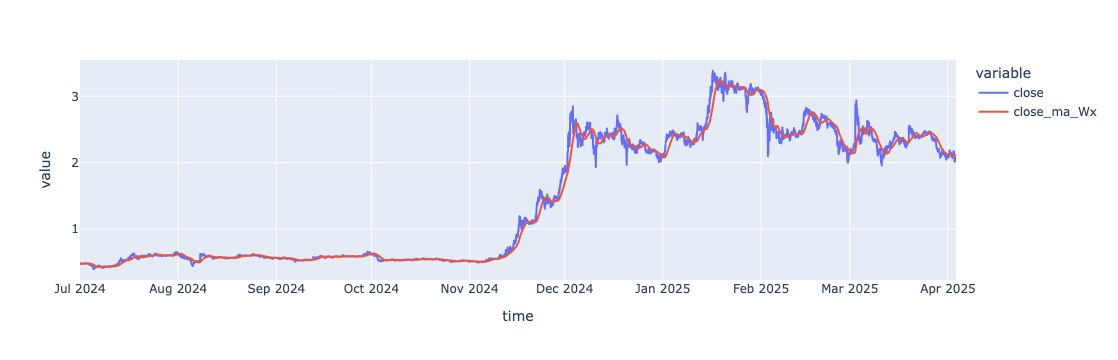

In [36]:
import plotly.express as px

ticker = "XRP-USDT"
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

window = 60
df[f'close_ma_Wx'] = df[f'close'].rolling(window=window, min_periods=window).mean().values


mask = df['time'] >= pd.Timestamp('2024-07-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx']].set_index('time'))

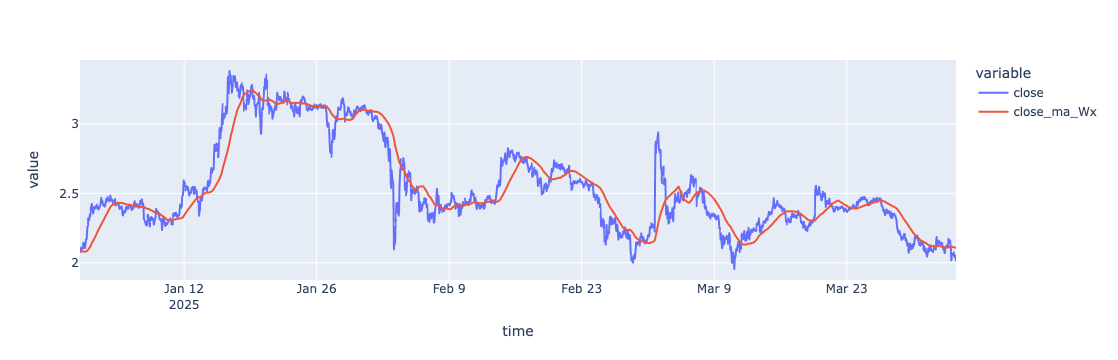

In [38]:
mask = df['time'] >= pd.Timestamp('2025-01-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx',]].set_index('time'))

In [40]:
x1, x2, x3, x4, x5 = df[f'close_ma_Wx'].iloc[-5:].tolist()
flag_long(x1, x2, x3, x4, x5)

False

In [ ]:
#Статистика: 

In [202]:
# 188 AAVE-USDT 	short 	30 	

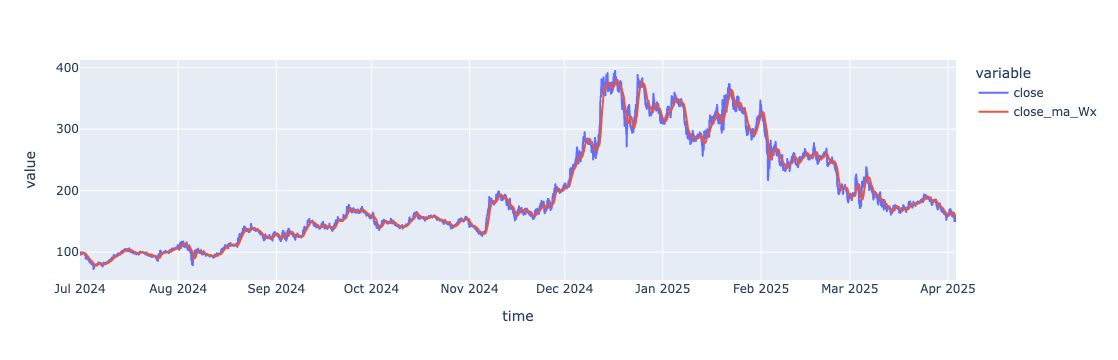

In [42]:
import plotly.express as px

ticker = "AAVE-USDT"
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

window = 30
df[f'close_ma_Wx'] = df[f'close'].rolling(window=window, min_periods=window).mean().values


mask = df['time'] >= pd.Timestamp('2024-07-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx']].set_index('time'))

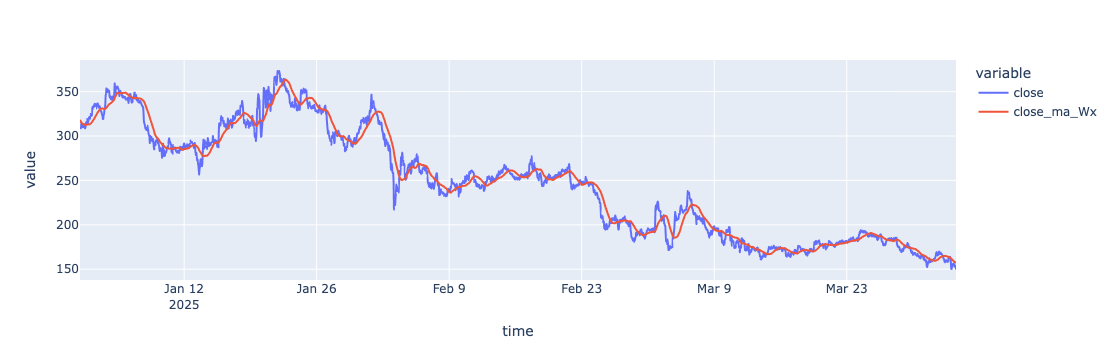

In [44]:
mask = df['time'] >= pd.Timestamp('2025-01-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx',]].set_index('time'))

In [46]:
x1, x2, x3, x4, x5 = df[f'close_ma_Wx'].iloc[-5:].tolist()
flag_short(x1, x2, x3, x4, x5)

False

In [25]:
# 138 	DOGE-USDT 	short 	90 	

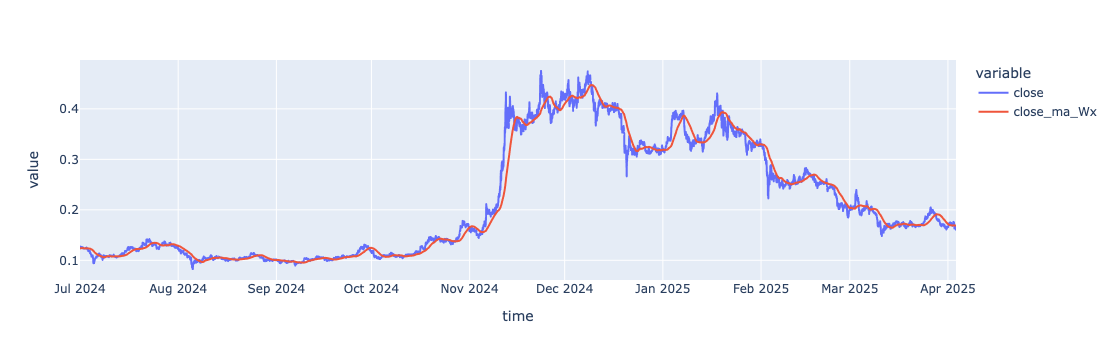

In [48]:
import plotly.express as px

ticker = "DOGE-USDT"
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

window = 90
df[f'close_ma_Wx'] = df[f'close'].rolling(window=window, min_periods=window).mean().values


mask = df['time'] >= pd.Timestamp('2024-07-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx']].set_index('time'))

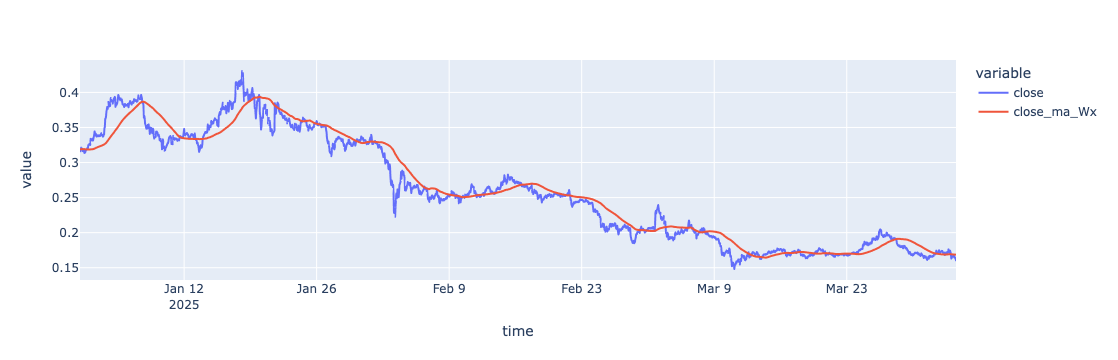

In [50]:
mask = df['time'] >= pd.Timestamp('2025-01-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx',]].set_index('time'))

In [52]:
x1, x2, x3, x4, x5 = df[f'close_ma_Wx'].iloc[-5:].tolist()
flag_short(x1, x2, x3, x4, x5)

False

In [33]:
#Статистика: +, 